In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

def compare_annotations_gff3_to_pdf_coords(
    gff3_A,
    gff3_B,
    gffcompare_annotated_gtf,
    gffcompare_loci,
    output_pdf,
    toolA_name="Tool A",
    toolB_name="Tool B",
    bins=50
):
    """
    Reference-free comparison of two GFF3 annotations.
    Handles tool-specific transcripts using coordinates (seqid, start, end, strand)
    Saves plots and tables into a single PDF.
    """

    sns.set_style("whitegrid")
    sns.set_palette("pastel")
    plt.rcParams.update({'figure.autolayout': True})

    # --------------------
    # Helper functions
    # --------------------
    def load_gff(path):
        cols = ["seqid", "source", "feature", "start", "end",
                "score", "strand", "phase", "attributes"]
        return pd.read_csv(path, sep="\t", comment="#", names=cols)

    def transcript_lengths(df):
        tx = df[df.feature.isin(["mRNA", "transcript"])].copy()
        tx["length"] = tx["end"] - tx["start"] + 1
        return tx[["seqid", "start", "end", "strand", "length", "attributes"]]

    def exon_count(df):
        exons = df[df.feature == "exon"].copy()
        # handle different formats: ID= or Parent=
        exons["parent"] = exons["attributes"].str.extract(r'(?:Parent|ID)=([^;]+)')
        return exons.groupby("parent").size()

    def map_transcripts(tx_cmp, tx_gff):
        """
        Map gffcompare transcripts to GFF3 transcripts using fuzzy overlap.
        Returns dataframe with length, exon count, mono-exonic info.
        """
        merged_list = []
        for idx, cmp_row in tx_cmp.iterrows():
            # filter GFF3 transcripts on same seqid and strand
            candidates = tx_gff[(tx_gff.seqid == cmp_row.seqid) & (tx_gff.strand == cmp_row.strand)]
            # check overlap
            overlap = candidates[(candidates.start <= cmp_row.end) & (candidates.end >= cmp_row.start)]
            if not overlap.empty:
                # take first overlapping transcript
                match = overlap.iloc[0].copy()
                match["class_code"] = cmp_row.class_code
                merged_list.append(match)
            else:
                # no overlap found
                missing = cmp_row.copy()
                missing["length"] = 0
                missing["class_code"] = cmp_row.class_code
                merged_list.append(missing)
        return pd.DataFrame(merged_list)

    # --------------------
    # Load GFF3s and gffcompare GTF
    # --------------------
    A = load_gff(gff3_A)
    B = load_gff(gff3_B)
    C = load_gff(gffcompare_annotated_gtf)

    tx_cmp = C[C.feature == "transcript"].copy()
    tx_cmp["class_code"] = tx_cmp["attributes"].str.extract(r'class_code "([^"]+)"')

    # Shared vs tool-specific
    shared = (tx_cmp.class_code == "=").sum()
    tool_specific = (tx_cmp.class_code == "u").sum()

    # --------------------
    # Transcript stats for each tool
    # --------------------
    toolA_tx = transcript_lengths(A)
    toolB_tx = transcript_lengths(B)

    mapped_A = map_transcripts(tx_cmp, toolA_tx)
    mapped_B = map_transcripts(tx_cmp, toolB_tx)

    # Exon counts
    exons_A = exon_count(A)
    exons_B = exon_count(B)
    mapped_A["exon_count"] = mapped_A["attributes"].str.extract(r'(?:Parent|ID)=([^;]+)')[0].map(exons_A).fillna(0)
    mapped_B["exon_count"] = mapped_B["attributes"].str.extract(r'(?:Parent|ID)=([^;]+)')[0].map(exons_B).fillna(0)

    # Compute metrics
    def compute_stats(mapped):
        lengths = mapped["length"]
        mean_len = lengths.mean()
        median_len = lengths.median()
        mean_exon = mapped["exon_count"].mean()
        median_exon = mapped["exon_count"].median()
        max_exon = mapped["exon_count"].max()
        min_exon = mapped["exon_count"].min()
        mono_tx = (mapped["exon_count"] == 1).sum()
        mono_percent = round(100 * mono_tx / len(mapped), 2) if len(mapped) > 0 else 0
        return mean_len, median_len, mean_exon, median_exon, max_exon, min_exon, mono_percent

    stats_A = compute_stats(mapped_A)
    stats_B = compute_stats(mapped_B)

    # Shared loci
    loci = pd.read_csv(gffcompare_loci, sep="\t", header=None)
    shared_loci = loci.shape[0]

    summary = pd.DataFrame({
        "Metric": [
            "Shared transcripts",
            "Tool-specific transcript count",
            "Mono-exonic transcripts (%)",
            "Mean length",
            "Median length",
            "Mean exon count",
            "Median exon count",
            "Max exon count",
            "Min exon count",
            "Shared loci"
        ],
        toolA_name: [
            shared,
            len(mapped_A[mapped_A.class_code == "u"]),
            stats_A[-1],
            stats_A[0],
            stats_A[1],
            stats_A[2],
            stats_A[3],
            stats_A[4],
            stats_A[5],
            shared_loci
        ],
        toolB_name: [
            shared,
            len(mapped_B[mapped_B.class_code == "u"]),
            stats_B[-1],
            stats_B[0],
            stats_B[1],
            stats_B[2],
            stats_B[3],
            stats_B[4],
            stats_B[5],
            shared_loci
        ]
    })

    # -------------------- Save PDF --------------------
    with PdfPages(output_pdf) as pdf:
        # Bar plot: Shared vs tool-specific
        plt.figure()
        sns.barplot(
            x=["Shared (=)", "Tool-specific (u)"],
            y=[shared, tool_specific]
        )
        plt.ylabel("Transcript count")
        plt.title("Shared vs Tool-specific transcripts")
        pdf.savefig()
        plt.close()

        # Histogram: transcript length
        plt.figure()
        sns.histplot(toolA_tx["length"], bins=bins, color=sns.color_palette("pastel")[0], label=toolA_name, kde=False, alpha=0.6)
        sns.histplot(toolB_tx["length"], bins=bins, color=sns.color_palette("pastel")[1], label=toolB_name, kde=False, alpha=0.6)
        plt.xlabel("Transcript length (bp)")
        plt.ylabel("Count")
        plt.legend()
        plt.title("Transcript length distribution")
        pdf.savefig()
        plt.close()

        # Pie chart: class_code distribution
        plt.figure()
        class_counts = Counter(tx_cmp["class_code"])
        plt.pie(class_counts.values(), labels=class_counts.keys(), autopct="%1.1f%%", colors=sns.color_palette("pastel", len(class_counts)))
        plt.title("gffcompare class_code distribution")
        pdf.savefig()
        plt.close()

        # Summary table
        fig, ax = plt.subplots()
        ax.axis("off")
        tbl = ax.table(cellText=summary.values, colLabels=summary.columns, loc="center")
        tbl.scale(1, 1.5)
        ax.set_title("Annotation comparison summary", pad=20)
        pdf.savefig(fig)
        plt.close(fig)

    return summary


summary = compare_annotations_gff3_to_pdf_coords(
	gff3_A="/Users/lazar/Documents/Fungi_BBR/compare/Coccidioides_immitis/helixer.gff3",
	gff3_B="/Users/lazar/Documents/Fungi_BBR/compare/Coccidioides_immitis/anno_annotation.gff3",
	gffcompare_annotated_gtf="/Users/lazar/Documents/Fungi_BBR/compare/Coccidioides_immitis/anno_vs_helixer/H_vs_A.annotated.gtf",
	gffcompare_loci="//Users/lazar/Documents/Fungi_BBR/compare/Coccidioides_immitis/anno_vs_helixer/H_vs_A.loci",
	toolA_name="Helixer",
	toolB_name="Anno",
	output_pdf="/Users/lazar/Documents/Fungi_BBR/compare/Coccidioides_immitis/anno_vs_helixer/H_vs_A_coord.pdf"
)

summary

,Metric,Helixer,Anno
0,Shared transcripts,2991.000000,2991.000000
1,Tool-specific transcript count,3024.000000,3024.000000
2,Mono-exonic transcripts (%),0.000000,4.720000
3,Mean length,1541.120114,1629.803942
4,Median length,1452.000000,1430.000000
5,Mean exon count,0.000000,3.428440
6,Median exon count,0.000000,3.000000
7,Max exon count,0.000000,54.000000
8,Min exon count,0.000000,0.000000
9,Shared loci,13249.000000,13249.000000


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns


def compare_annotations_gff3_to_pdf(
		gff3_A,
		gff3_B,
		gffcompare_A_vs_B_gtf,  # A as query, B as reference
		gffcompare_B_vs_A_gtf,  # B as query, A as reference
		gffcompare_loci,
		output_pdf,
		toolA_name="Tool A",
		toolB_name="Tool B",
		bins=50
):
    """
    Reference-free comparison of two GFF3 annotations using bidirectional gffcompare.
    Enhanced tool-specific transcript analysis.
    Saves all plots and summary tables into a single PDF.

    Parameters:
    -----------
    gff3_A : str
        Path to Tool A GFF3 file
    gff3_B : str
        Path to Tool B GFF3 file
    gffcompare_A_vs_B_gtf : str
        Path to gffcompare output with A as query, B as reference
    gffcompare_B_vs_A_gtf : str
        Path to gffcompare output with B as query, A as reference
    gffcompare_loci : str
        Path to gffcompare loci file
    output_pdf : str
        Path for output PDF report
    toolA_name : str
        Display name for Tool A
    toolB_name : str
        Display name for Tool B
    bins : int
        Number of bins for histograms
    """

    # Plot setup
    sns.set_style("whitegrid")
    sns.set_palette("pastel")
    plt.rcParams.update({'figure.autolayout': True})

    # --------------------
    # Helper functions
    # --------------------
    def load_gff(path):
        cols = ["seqid", "source", "feature", "start", "end",
                "score", "strand", "phase", "attributes"]
        return pd.read_csv(path, sep="\t", comment="#", names=cols)

    def transcript_lengths(df):
        tx = df[df.feature.isin(["mRNA", "transcript"])].copy()
        tx["length"] = tx["end"] - tx["start"] + 1
        return tx["length"]

    def mono_exonic_percent(df):
        exons = df[df.feature == "exon"].copy()
        exons["parent"] = exons["attributes"].str.extract(r'Parent=([^;]+)')
        exon_counts = exons.groupby("parent").size()
        mono = (exon_counts == 1).sum()
        total = exon_counts.size
        return round(100 * mono / total, 2) if total > 0 else 0

    def exon_counts(df):
        exons = df[df.feature == "exon"].copy()
        exons["parent"] = exons["attributes"].str.extract(r'Parent=([^;]+)')
        return exons.groupby("parent").size()

    def get_tool_specific_transcripts(gff_df, gffcompare_gtf):
        """Extract tool-specific transcripts (class_code 'u')"""
        cmp = load_gff(gffcompare_gtf)
        cmp["class_code"] = cmp["attributes"].str.extract(r'class_code "([^"]+)"')
        tx_cmp = cmp[cmp.feature == "transcript"]

        # Get transcript IDs that are tool-specific
        specific_tx = tx_cmp[tx_cmp.class_code == "u"]

        # Extract transcript IDs from the specific transcripts
        specific_tx["transcript_id"] = specific_tx["attributes"].str.extract(r'transcript_id "([^"]+)"')

        # Return a subset of the original GFF for these transcripts
        return specific_tx

    # --------------------
    # Load data
    # --------------------
    A = load_gff(gff3_A)
    B = load_gff(gff3_B)

    # Load both gffcompare results
    C_A_vs_B = load_gff(gffcompare_A_vs_B_gtf)
    C_B_vs_A = load_gff(gffcompare_B_vs_A_gtf)

    # Extract class codes from both comparisons
    C_A_vs_B["class_code"] = C_A_vs_B["attributes"].str.extract(r'class_code "([^"]+)"')
    C_B_vs_A["class_code"] = C_B_vs_A["attributes"].str.extract(r'class_code "([^"]+)"')

    tx_A_vs_B = C_A_vs_B[C_A_vs_B.feature == "transcript"]
    tx_B_vs_A = C_B_vs_A[C_B_vs_A.feature == "transcript"]

    class_counts_A = Counter(tx_A_vs_B["class_code"])
    class_counts_B = Counter(tx_B_vs_A["class_code"])

    # Tool-specific transcripts (class code 'u' = no overlap with reference)
    toolA_specific_df = tx_A_vs_B[tx_A_vs_B.class_code == "u"]
    toolB_specific_df = tx_B_vs_A[tx_B_vs_A.class_code == "u"]

    # Shared transcripts (class code '=' = exact match)
    shared_A = class_counts_A.get("=", 0)
    shared_B = class_counts_B.get("=", 0)
    shared = (shared_A + shared_B) // 2  # Average to avoid double counting

    # Mono-exonic percentages
    mono_A = mono_exonic_percent(A)
    mono_B = mono_exonic_percent(B)

    # Shared loci
    loci = pd.read_csv(gffcompare_loci, sep="\t", header=None)
    shared_loci = loci.shape[0]

    # Total transcripts
    total_tx_A = len(A[A.feature.isin(["mRNA", "transcript"])])
    total_tx_B = len(B[B.feature.isin(["mRNA", "transcript"])])

    # --------------------
    # Extended summary
    # --------------------
    summary = pd.DataFrame({
        "Metric": [
            "Total transcripts",
            "Shared transcripts (=)",
            "Tool-specific transcripts (u)",
            "Mono-exonic transcripts (%)",
            "Mean transcript length (bp)",
            "Mean exon count (all)",
            "Mean exon count (tool-specific)"
        ],
        toolA_name: [
            total_tx_A,
            shared,
            len(toolA_specific_df),
            mono_A,
            transcript_lengths(A).mean() if len(transcript_lengths(A)) > 0 else 0,
            exon_counts(A).mean() if len(exon_counts(A)) > 0 else 0,
            exon_counts(toolA_specific_df).mean() if not toolA_specific_df.empty else 0
        ],
        toolB_name: [
            total_tx_B,
            shared,
            len(toolB_specific_df),
            mono_B,
            transcript_lengths(B).mean() if len(transcript_lengths(B)) > 0 else 0,
            exon_counts(B).mean() if len(exon_counts(B)) > 0 else 0,
            exon_counts(toolB_specific_df).mean() if not toolB_specific_df.empty else 0
        ]
    })

    # Add shared loci as a separate row
    shared_row = pd.DataFrame({
        "Metric": ["Shared loci"],
        toolA_name: [shared_loci],
        toolB_name: [shared_loci]
    })
    summary = pd.concat([summary, shared_row], ignore_index=True)

    # -------------------- Save PDF --------------------
    with PdfPages(output_pdf) as pdf:

        # 1. Shared vs tool-specific
        plt.figure(figsize=(10, 6))
        data_to_plot = pd.DataFrame({
            'Category': ['Shared', f'{toolA_name}-specific', f'{toolB_name}-specific'],
            'Count': [shared, len(toolA_specific_df), len(toolB_specific_df)]
        })
        sns.barplot(data=data_to_plot, x='Category', y='Count', palette='pastel')
        plt.ylabel("Transcript count")
        plt.title("Shared vs Tool-specific transcripts")
        plt.xticks(rotation=15, ha='right')
        pdf.savefig()
        plt.close()

        # 2. Transcript length histogram
        plt.figure(figsize=(10, 6))

        len_A = transcript_lengths(A)
        len_B = transcript_lengths(B)

        if len(len_A) > 0:
            sns.histplot(
                len_A,
                bins=bins,
                stat="count",
                element="step",
                fill=True,
                alpha=0.5,
                label=toolA_name,
            )

        if len(len_B) > 0:
            sns.histplot(
                len_B,
                bins=bins,
                stat="count",
                element="step",
                fill=True,
                alpha=0.5,
                label=toolB_name,
            )

        plt.xlabel("Transcript length (bp)")
        plt.ylabel("Transcript count")
        plt.title("Transcript length distribution")
        plt.legend()

        pdf.savefig()
        plt.close()

        # 3. Tool-specific exon count histogram
        plt.figure(figsize=(10, 6))
        if not toolA_specific_df.empty:
            ex_A = exon_counts(toolA_specific_df)
            if len(ex_A) > 0:
                sns.histplot(ex_A, bins=bins, color=sns.color_palette("pastel")[0], label=f"{toolA_name}-specific", alpha=0.6, stat='density')
        if not toolB_specific_df.empty:
            ex_B = exon_counts(toolB_specific_df)
            if len(ex_B) > 0:
                sns.histplot(ex_B, bins=bins, color=sns.color_palette("pastel")[1], label=f"{toolB_name}-specific", alpha=0.6, stat='density')
        plt.xlabel("Exon count per transcript")
        plt.ylabel("Density")
        plt.legend()
        plt.title("Exon count distribution for tool-specific transcripts")
        pdf.savefig()
        plt.close()

        # 4. Combined pie chart: class_code distribution for both tools
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

        # Tool A class codes
        if len(class_counts_A) > 0:
            ax1.pie(
                class_counts_A.values(),
                labels=class_counts_A.keys(),
                autopct="%1.1f%%",
                colors=sns.color_palette("pastel", len(class_counts_A))
            )
            ax1.set_title(f"{toolA_name} class_code distribution\n(vs {toolB_name} as reference)")

        # Tool B class codes
        if len(class_counts_B) > 0:
            ax2.pie(
                class_counts_B.values(),
                labels=class_counts_B.keys(),
                autopct="%1.1f%%",
                colors=sns.color_palette("pastel", len(class_counts_B))
            )
            ax2.set_title(f"{toolB_name} class_code distribution\n(vs {toolA_name} as reference)")

        plt.tight_layout()
        pdf.savefig(fig)
        plt.close(fig)

        # 5. Summary table
        fig, ax = plt.subplots(figsize=(10, 8))
        ax.axis("off")
        tbl = ax.table(
            cellText=summary.values,
            colLabels=summary.columns,
            loc="center",
            cellLoc='left'
        )
        tbl.auto_set_font_size(False)
        tbl.set_fontsize(9)
        tbl.scale(1, 2)
        ax.set_title("Annotation comparison summary", pad=20, fontsize=14, fontweight='bold')
        pdf.savefig(fig, bbox_inches='tight')
        plt.close(fig)

    print(f"PDF report saved to: {output_pdf}")
    return summary

summary = compare_annotations_gff3_to_pdf(
	gff3_A="/Users/lazar/Documents/Fungi_BBR/compare/Coccidioides_immitis/anno_annotation.gtf",
	gff3_B="/Users/lazar/Documents/Fungi_BBR/compare/Coccidioides_immitis/helixer_anno_annotation_fixed.gtf",
	gffcompare_A_vs_B_gtf="/Users/lazar/Documents/Fungi_BBR/compare/Coccidioides_immitis/anno_vs_helixer_layered/Anno_vs_Helixer_layered.annotated.gtf",
    gffcompare_B_vs_A_gtf="/Users/lazar/Documents/Fungi_BBR/compare/Coccidioides_immitis/anno_vs_helixer_layered/Helixer_layered_vs_Anno.annotated.gtf",
	gffcompare_loci="//Users/lazar/Documents/Fungi_BBR/compare/Coccidioides_immitis/anno_vs_helixer_layered/Anno_vs_Helixer_layered.loci",
	toolA_name="Anno",
	toolB_name="Helixer_layered",
	output_pdf="/Users/lazar/Documents/Fungi_BBR/compare/Coccidioides_immitis/anno_vs_helixer_layered/Anno_vs_Helixer_layered.pdf"
)

summary

/var/folders/qj/dngfdyvx27gg8wt1y1mz7j4r0000gp/T/ipykernel_25580/1523541834.py:183: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data_to_plot, x='Category', y='Count', palette='pastel')
/var/folders/qj/dngfdyvx27gg8wt1y1mz7j4r0000gp/T/ipykernel_25580/1523541834.py:238: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


PDF report saved to: /Users/lazar/Documents/Fungi_BBR/compare/Coccidioides_immitis/anno_vs_helixer_layered/Anno_vs_Helixer_layered.pdf


,Metric,Anno,Helixer_layered
0,Total transcripts,20434.000000,17615.000000
1,Shared transcripts (=),15387.000000,15387.000000
2,Tool-specific transcripts (u),87.000000,87.000000
3,Mono-exonic transcripts (%),0.000000,0.000000
4,Mean transcript length (bp),1898.633992,1975.806358
5,Mean exon count (all),0.000000,0.000000
6,Mean exon count (tool-specific),NaN,NaN
7,Shared loci,11348.000000,11348.000000


# BUSCO full vs canonical


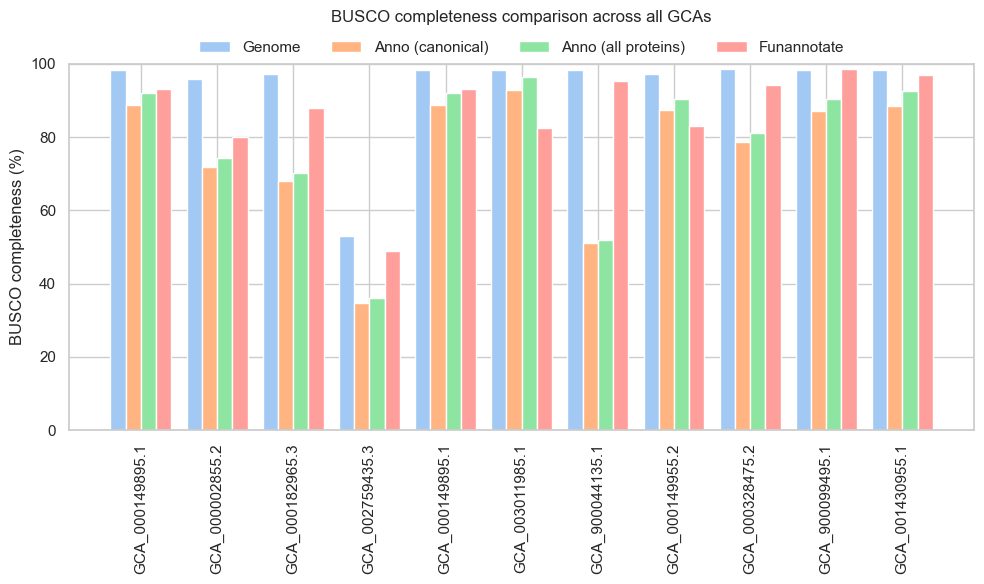

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
import seaborn as sns


# -------- user input --------
csv_path = "/Users/lazar/Desktop/busco_test.csv"   # path to your CSV
# ----------------------------

# read CSV
df = pd.read_csv(csv_path)

# extract BUSCO completeness (C:xx.x%)
def extract_c(busco_str):
    if pd.isna(busco_str):
        return None
    m = re.search(r"C:(\d+\.?\d*)%", busco_str)
    return float(m.group(1)) if m else None

busco_cols = [
    "Genome_BUSCO",
    "Anno_BUSCO_canonical",
    "Anno_BUSCO_all_proteins",
    "Funannotate_BUSCO",
]

for col in busco_cols:
    df[col + "_C"] = df[col].apply(extract_c)

# data for plotting
labels = ["Genome", "Anno (canonical)", "Anno (all proteins)", "Funannotate"]
values = df[[c + "_C" for c in busco_cols]].to_numpy()

x = np.arange(len(df))  # one position per GCA
width = 0.2

# plot grouped bars
sns.set_theme(style="whitegrid", palette="pastel")

plt.figure(figsize=(max(10, len(df) * 0.6), 6))

for i in range(values.shape[1]):
    plt.bar(x + i * width, values[:, i], width, label=labels[i])

plt.xticks(x + width * (len(labels) - 1) / 2, df["GCA"], rotation=90)
plt.ylabel("BUSCO completeness (%)")
plt.ylim(0, 100)

plt.title("BUSCO completeness comparison across all GCAs", pad=30)

plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 1.10),
    ncol=len(labels),
    frameon=False,
)

plt.tight_layout()
plt.show()

# extra plot genes

In [24]:
import matplotlib.pyplot as plt
from collections import defaultdict

def plot_gene_length_and_exon_distributions(
    gff_file,
    short_length_bp=300,
    min_exons=2
):
    """
    Plot gene length and exon count distributions from a GFF3 file,
    and report very short multi-exonic genes.

    Parameters
    ----------
    gff_file : str
        Path to GFF3 file
    short_length_bp : int
        Max gene length to be considered 'very short'
    min_exons : int
        Minimum exon count to be considered multi-exonic
    """

    gene_coords = {}
    transcript_to_gene = {}
    gene_exon_counts = defaultdict(int)

    def parse_attrs(attr_str):
        return dict(
            item.split("=", 1)
            for item in attr_str.strip().split(";")
            if "=" in item
        )

    with open(gff_file) as fh:
        for line in fh:
            if line.startswith("#"):
                continue
            fields = line.rstrip().split("\t")
            if len(fields) != 9:
                continue

            seqid, source, feature, start, end, score, strand, phase, attrs = fields
            start, end = int(start), int(end)
            attrd = parse_attrs(attrs)

            if feature == "gene":
                gene_id = attrd.get("ID")
                if gene_id:
                    gene_coords[gene_id] = (start, end)

            elif feature in {"mRNA", "transcript"}:
                tid = attrd.get("ID")
                gid = attrd.get("Parent")
                if tid and gid:
                    transcript_to_gene[tid] = gid

            elif feature == "exon":
                parents = attrd.get("Parent", "").split(",")
                for tid in parents:
                    gid = transcript_to_gene.get(tid)
                    if gid:
                        gene_exon_counts[gid] += 1

    # Compute gene lengths
    gene_lengths = []
    exon_counts = []
    short_multi_exonic = []

    for gid, (start, end) in gene_coords.items():
        length = end - start + 1
        exons = gene_exon_counts.get(gid, 0)

        gene_lengths.append(length)
        exon_counts.append(exons)

        if length <= short_length_bp and exons >= min_exons:
            short_multi_exonic.append((gid, length, exons))

    # Plot gene length distribution
    plt.figure()
    plt.hist(gene_lengths, bins=50)
    plt.xlabel("Gene length (bp)")
    plt.ylabel("Count")
    plt.title("Gene length distribution")
    plt.tight_layout()
    plt.show()

    # Plot exon count distribution
    plt.figure()
    plt.hist(exon_counts, bins=range(1, max(exon_counts) + 2))
    plt.xlabel("Exon count per gene")
    plt.ylabel("Count")
    plt.title("Exon count distribution")
    plt.tight_layout()
    plt.show()

    # Scatter plot: gene length vs exon count
    plt.figure()

    # All genes
    plt.scatter(gene_lengths, exon_counts, alpha=0.4)

    # Highlight short multi-exonic genes
    short_lengths = [x[1] for x in short_multi_exonic]
    short_exons = [x[2] for x in short_multi_exonic]
    plt.scatter(short_lengths, short_exons)

    # Threshold lines
    plt.axvline(short_length_bp)
    plt.axhline(min_exons)

    plt.xlabel("Gene length (bp)")
    plt.ylabel("Exon count per gene")
    plt.title("Gene length vs exon count")

    plt.tight_layout()
    plt.show()

    return short_multi_exonic

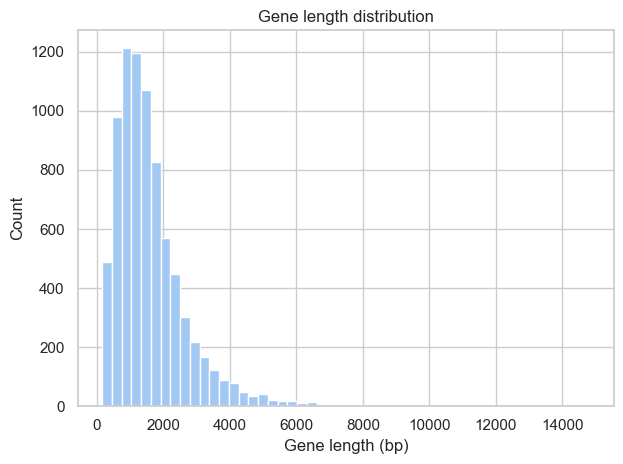

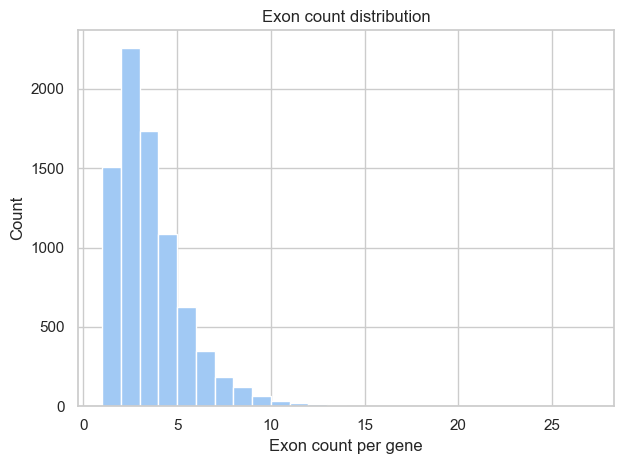

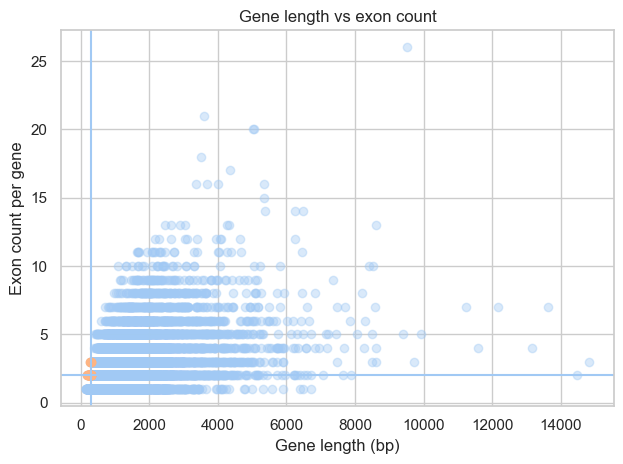

[('FUN_000262', 259, 2),
 ('FUN_000266', 254, 2),
 ('FUN_000401', 300, 3),
 ('FUN_000821', 267, 2),
 ('FUN_001000', 291, 2),
 ('FUN_001137', 255, 2),
 ('FUN_002443', 245, 2),
 ('FUN_003291', 294, 3),
 ('FUN_003363', 272, 2),
 ('FUN_003433', 267, 2),
 ('FUN_004021', 279, 2),
 ('FUN_004471', 285, 2),
 ('FUN_004560', 297, 2),
 ('FUN_004748', 273, 2),
 ('FUN_004754', 252, 2),
 ('FUN_004861', 233, 2),
 ('FUN_004918', 198, 2),
 ('FUN_004954', 258, 2),
 ('FUN_005638', 274, 2),
 ('FUN_006108', 284, 3),
 ('FUN_006118', 215, 2),
 ('FUN_006352', 251, 2),
 ('FUN_006603', 254, 2),
 ('FUN_006870', 273, 2),
 ('FUN_007066', 290, 2),
 ('FUN_007153', 214, 2),
 ('FUN_007203', 237, 2),
 ('FUN_007529', 269, 2),
 ('FUN_007608', 271, 2),
 ('FUN_007629', 298, 2),
 ('FUN_007791', 299, 2)]

In [26]:
plot_gene_length_and_exon_distributions("/Users/lazar/Documents/Fungi_BBR/compare/Coccidioides_immitis/Coccidioides_Immitis.gff3")